# Read-me

- In this notebook, we applied feature engineering to improve features for our models.
- We apply transformations to remove distortion and we derivate time features.
- The RSD variable idea was created from here: https://en.wikipedia.org/wiki/Coefficient_of_variation
- We also remove feats from Pearson correlation that is larger than 0.98
- We apply scaling method as we want to prepare features for multiple models that need scaling (i.e LogisticRegression)
- As not all features are necessary, we run a feature selection using the recursive method.
- Finally, we compare the results with logistic regression.
- From the results, we observe recall, precision, average-precision-recall and roc auc from our model with feature engineering got better results than from logistic regression of the baseline.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from lib.utils import *

# Load data

In [5]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
df = pd.read_csv('data/data.csv',sep=';')
df.head()

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude
0,01/03/2020,5e74d202d1498c5bdf8aafe3,cnpj,6000,"4884,61",63500,"2122,83",10,13,0,35,11,0,0
1,01/03/2020,5e78dafeb5ac867c7e85eb5e,cnpj,1800,1800,3600,0,0,2,0,0,11,0,0
2,01/03/2020,5e73e21359193c2f123c1076,cnpj,"159,9","104,9","209,8","77,78",0,2,0,14,11,0,0
3,01/04/2020,5e7262c49d55ea5dbea59d57,cnpj,600,600,1800,0,0,3,0,18,11,0,0
4,01/04/2020,5e610d9f66945c0f82dd357f,cnpj,2941,"1764,6",8823,"657,63",2,5,0,65,12,0,0


In [7]:
from lib.utils import *
df = change_portuguese_to_english_cols(df)

# Feature engineering

In [13]:
company_train = np.load("data/input/company_train.npy",allow_pickle=True)
company_test = np.load("data/input/company_test.npy",allow_pickle=True)
feats = np.load('data/input/feats.npy')

## Categorical to numerical

In [34]:
df['tipo_doc'] = df.tipo_doc.astype('category').cat.codes

## Log boletos 

- To smooth outliers and skewed distribution

In [14]:
from math import log
df['max_valor_boleto_log'] = df.max_valor_boleto.apply(log)
df['avg_valor_boleto_log'] = df.avg_valor_boleto.apply(log)
df['total_valor_boleto_log'] = df.total_valor_boleto.apply(log)
df['valor_boleto_stdv_log'] = (df.valor_boleto_stdv + 1).apply(log)
df.head()

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,max_valor_boleto_log,avg_valor_boleto_log,total_valor_boleto_log,valor_boleto_stdv_log
0,01/03/2020,5e74d202d1498c5bdf8aafe3,cnpj,6000.000000,4884.609863,63500.000000,2122.830078,10,13,0,35,11,0,0,8.699515,8.493845,11.058795,7.660976
1,01/03/2020,5e78dafeb5ac867c7e85eb5e,cnpj,1800.000000,1800.000000,3600.000000,0.000000,0,2,0,0,11,0,0,7.495542,7.495542,8.188689,0.000000
2,01/03/2020,5e73e21359193c2f123c1076,cnpj,159.899994,104.900002,209.800003,77.779999,0,2,0,14,11,0,0,5.074549,4.653008,5.346155,4.366659
3,01/04/2020,5e7262c49d55ea5dbea59d57,cnpj,600.000000,600.000000,1800.000000,0.000000,0,3,0,18,11,0,0,6.396930,6.396930,7.495542,0.000000
4,01/04/2020,5e610d9f66945c0f82dd357f,cnpj,2941.000000,1764.599976,8823.000000,657.630005,2,5,0,65,12,0,0,7.986505,7.475679,9.085117,6.490162


In [15]:
feats = set(feats)
feats

{'avg_valor_boleto',
 'conta_bnk_repetida',
 'max_valor_boleto',
 'qnt_cc_total',
 'qtd_boleto_estorno',
 'qtd_boleto_pago',
 'qtd_boleto_total',
 'tempo_credenciamento',
 'tipo_doc',
 'total_valor_boleto',
 'valor_boleto_stdv'}

In [16]:
feats = feats.union(['max_valor_boleto_log','avg_valor_boleto_log','total_valor_boleto_log', 'valor_boleto_stdv_log'])

## datetime
- to interpret time 

In [17]:
df['month'] = pd.to_datetime(df.mes_ref).dt.hour
df.head()

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,max_valor_boleto_log,avg_valor_boleto_log,total_valor_boleto_log,valor_boleto_stdv_log,month
0,01/03/2020,5e74d202d1498c5bdf8aafe3,cnpj,6000.000000,4884.609863,63500.000000,2122.830078,10,13,0,35,11,0,0,8.699515,8.493845,11.058795,7.660976,0
1,01/03/2020,5e78dafeb5ac867c7e85eb5e,cnpj,1800.000000,1800.000000,3600.000000,0.000000,0,2,0,0,11,0,0,7.495542,7.495542,8.188689,0.000000,0
2,01/03/2020,5e73e21359193c2f123c1076,cnpj,159.899994,104.900002,209.800003,77.779999,0,2,0,14,11,0,0,5.074549,4.653008,5.346155,4.366659,0
3,01/04/2020,5e7262c49d55ea5dbea59d57,cnpj,600.000000,600.000000,1800.000000,0.000000,0,3,0,18,11,0,0,6.396930,6.396930,7.495542,0.000000,0
4,01/04/2020,5e610d9f66945c0f82dd357f,cnpj,2941.000000,1764.599976,8823.000000,657.630005,2,5,0,65,12,0,0,7.986505,7.475679,9.085117,6.490162,0


In [18]:
df['year'] = pd.to_datetime(df.mes_ref).dt.year
df.head()

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,max_valor_boleto_log,avg_valor_boleto_log,total_valor_boleto_log,valor_boleto_stdv_log,month,year
0,01/03/2020,5e74d202d1498c5bdf8aafe3,cnpj,6000.000000,4884.609863,63500.000000,2122.830078,10,13,0,35,11,0,0,8.699515,8.493845,11.058795,7.660976,0,2020
1,01/03/2020,5e78dafeb5ac867c7e85eb5e,cnpj,1800.000000,1800.000000,3600.000000,0.000000,0,2,0,0,11,0,0,7.495542,7.495542,8.188689,0.000000,0,2020
2,01/03/2020,5e73e21359193c2f123c1076,cnpj,159.899994,104.900002,209.800003,77.779999,0,2,0,14,11,0,0,5.074549,4.653008,5.346155,4.366659,0,2020
3,01/04/2020,5e7262c49d55ea5dbea59d57,cnpj,600.000000,600.000000,1800.000000,0.000000,0,3,0,18,11,0,0,6.396930,6.396930,7.495542,0.000000,0,2020
4,01/04/2020,5e610d9f66945c0f82dd357f,cnpj,2941.000000,1764.599976,8823.000000,657.630005,2,5,0,65,12,0,0,7.986505,7.475679,9.085117,6.490162,0,2020


In [19]:
df = df.drop('mes_ref',axis=1)
df.head(3)

,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,max_valor_boleto_log,avg_valor_boleto_log,total_valor_boleto_log,valor_boleto_stdv_log,month,year
0,5e74d202d1498c5bdf8aafe3,cnpj,6000.000000,4884.609863,63500.000000,2122.830078,10,13,0,35,11,0,0,8.699515,8.493845,11.058795,7.660976,0,2020
1,5e78dafeb5ac867c7e85eb5e,cnpj,1800.000000,1800.000000,3600.000000,0.000000,0,2,0,0,11,0,0,7.495542,7.495542,8.188689,0.000000,0,2020
2,5e73e21359193c2f123c1076,cnpj,159.899994,104.900002,209.800003,77.779999,0,2,0,14,11,0,0,5.074549,4.653008,5.346155,4.366659,0,2020


In [20]:
feats = feats.union(['month','year'])
feats

{'avg_valor_boleto',
 'avg_valor_boleto_log',
 'conta_bnk_repetida',
 'max_valor_boleto',
 'max_valor_boleto_log',
 'month',
 'qnt_cc_total',
 'qtd_boleto_estorno',
 'qtd_boleto_pago',
 'qtd_boleto_total',
 'tempo_credenciamento',
 'tipo_doc',
 'total_valor_boleto',
 'total_valor_boleto_log',
 'valor_boleto_stdv',
 'valor_boleto_stdv_log',
 'year'}

## RSD log

In [21]:
df['rsd_valor_boleto_log'] = df['avg_valor_boleto_log']/df['total_valor_boleto_log']

<AxesSubplot:>

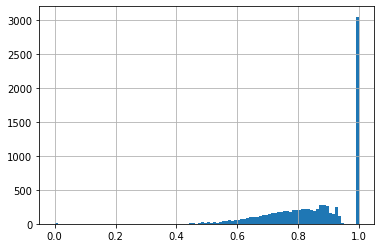

In [22]:
df.rsd_valor_boleto_log.hist(bins=100)

## Binning

In [23]:
df['qnt_cc_total_binned'] = pd.qcut(df.qnt_cc_total, 10,duplicates='drop').astype('category').cat.codes
df.head()

,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,...,conta_bnk_repetida,fraude,max_valor_boleto_log,avg_valor_boleto_log,total_valor_boleto_log,valor_boleto_stdv_log,month,year,rsd_valor_boleto_log,qnt_cc_total_binned
0,5e74d202d1498c5bdf8aafe3,cnpj,6000.000000,4884.609863,63500.000000,2122.830078,10,13,0,35,...,0,0,8.699515,8.493845,11.058795,7.660976,0,2020,0.768062,4
1,5e78dafeb5ac867c7e85eb5e,cnpj,1800.000000,1800.000000,3600.000000,0.000000,0,2,0,0,...,0,0,7.495542,7.495542,8.188689,0.000000,0,2020,0.915353,0
2,5e73e21359193c2f123c1076,cnpj,159.899994,104.900002,209.800003,77.779999,0,2,0,14,...,0,0,5.074549,4.653008,5.346155,4.366659,0,2020,0.870347,3
3,5e7262c49d55ea5dbea59d57,cnpj,600.000000,600.000000,1800.000000,0.000000,0,3,0,18,...,0,0,6.396930,6.396930,7.495542,0.000000,0,2020,0.853431,4
4,5e610d9f66945c0f82dd357f,cnpj,2941.000000,1764.599976,8823.000000,657.630005,2,5,0,65,...,0,0,7.986505,7.475679,9.085117,6.490162,0,2020,0.822849,4


In [24]:
df['qtd_boleto_pago_binned'] = pd.qcut(df.qtd_boleto_pago, 100,duplicates='drop').astype('category').cat.codes
df.head()

,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,...,fraude,max_valor_boleto_log,avg_valor_boleto_log,total_valor_boleto_log,valor_boleto_stdv_log,month,year,rsd_valor_boleto_log,qnt_cc_total_binned,qtd_boleto_pago_binned
0,5e74d202d1498c5bdf8aafe3,cnpj,6000.000000,4884.609863,63500.000000,2122.830078,10,13,0,35,...,0,8.699515,8.493845,11.058795,7.660976,0,2020,0.768062,4,8
1,5e78dafeb5ac867c7e85eb5e,cnpj,1800.000000,1800.000000,3600.000000,0.000000,0,2,0,0,...,0,7.495542,7.495542,8.188689,0.000000,0,2020,0.915353,0,0
2,5e73e21359193c2f123c1076,cnpj,159.899994,104.900002,209.800003,77.779999,0,2,0,14,...,0,5.074549,4.653008,5.346155,4.366659,0,2020,0.870347,3,0
3,5e7262c49d55ea5dbea59d57,cnpj,600.000000,600.000000,1800.000000,0.000000,0,3,0,18,...,0,6.396930,6.396930,7.495542,0.000000,0,2020,0.853431,4,0
4,5e610d9f66945c0f82dd357f,cnpj,2941.000000,1764.599976,8823.000000,657.630005,2,5,0,65,...,0,7.986505,7.475679,9.085117,6.490162,0,2020,0.822849,4,1


In [25]:
df['qtd_boleto_total_binned'] = pd.qcut(df.qtd_boleto_total, 100,duplicates='drop').astype('category').cat.codes
df.head()

,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,...,max_valor_boleto_log,avg_valor_boleto_log,total_valor_boleto_log,valor_boleto_stdv_log,month,year,rsd_valor_boleto_log,qnt_cc_total_binned,qtd_boleto_pago_binned,qtd_boleto_total_binned
0,5e74d202d1498c5bdf8aafe3,cnpj,6000.000000,4884.609863,63500.000000,2122.830078,10,13,0,35,...,8.699515,8.493845,11.058795,7.660976,0,2020,0.768062,4,8,11
1,5e78dafeb5ac867c7e85eb5e,cnpj,1800.000000,1800.000000,3600.000000,0.000000,0,2,0,0,...,7.495542,7.495542,8.188689,0.000000,0,2020,0.915353,0,0,0
2,5e73e21359193c2f123c1076,cnpj,159.899994,104.900002,209.800003,77.779999,0,2,0,14,...,5.074549,4.653008,5.346155,4.366659,0,2020,0.870347,3,0,0
3,5e7262c49d55ea5dbea59d57,cnpj,600.000000,600.000000,1800.000000,0.000000,0,3,0,18,...,6.396930,6.396930,7.495542,0.000000,0,2020,0.853431,4,0,1
4,5e610d9f66945c0f82dd357f,cnpj,2941.000000,1764.599976,8823.000000,657.630005,2,5,0,65,...,7.986505,7.475679,9.085117,6.490162,0,2020,0.822849,4,1,3


In [26]:
df['qtd_boleto_total_binned'] = pd.qcut(df.qtd_boleto_estorno, 100,duplicates='drop').astype('category').cat.codes
df.head()

,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,...,max_valor_boleto_log,avg_valor_boleto_log,total_valor_boleto_log,valor_boleto_stdv_log,month,year,rsd_valor_boleto_log,qnt_cc_total_binned,qtd_boleto_pago_binned,qtd_boleto_total_binned
0,5e74d202d1498c5bdf8aafe3,cnpj,6000.000000,4884.609863,63500.000000,2122.830078,10,13,0,35,...,8.699515,8.493845,11.058795,7.660976,0,2020,0.768062,4,8,0
1,5e78dafeb5ac867c7e85eb5e,cnpj,1800.000000,1800.000000,3600.000000,0.000000,0,2,0,0,...,7.495542,7.495542,8.188689,0.000000,0,2020,0.915353,0,0,0
2,5e73e21359193c2f123c1076,cnpj,159.899994,104.900002,209.800003,77.779999,0,2,0,14,...,5.074549,4.653008,5.346155,4.366659,0,2020,0.870347,3,0,0
3,5e7262c49d55ea5dbea59d57,cnpj,600.000000,600.000000,1800.000000,0.000000,0,3,0,18,...,6.396930,6.396930,7.495542,0.000000,0,2020,0.853431,4,0,0
4,5e610d9f66945c0f82dd357f,cnpj,2941.000000,1764.599976,8823.000000,657.630005,2,5,0,65,...,7.986505,7.475679,9.085117,6.490162,0,2020,0.822849,4,1,0


# Remove feats from pearson corr

In [27]:
feats.remove('max_valor_boleto')

# Split

In [28]:
feats = list(feats)

In [29]:
feats

['total_valor_boleto_log',
 'month',
 'qtd_boleto_pago',
 'conta_bnk_repetida',
 'qtd_boleto_total',
 'avg_valor_boleto',
 'tempo_credenciamento',
 'qtd_boleto_estorno',
 'max_valor_boleto_log',
 'valor_boleto_stdv_log',
 'qnt_cc_total',
 'valor_boleto_stdv',
 'total_valor_boleto',
 'year',
 'tipo_doc',
 'avg_valor_boleto_log']

In [30]:
df.columns

Index(['company_id', 'tipo_doc', 'max_valor_boleto', 'avg_valor_boleto',
       'total_valor_boleto', 'valor_boleto_stdv', 'qtd_boleto_pago',
       'qtd_boleto_total', 'qtd_boleto_estorno', 'qnt_cc_total',
       'tempo_credenciamento', 'conta_bnk_repetida', 'fraude',
       'max_valor_boleto_log', 'avg_valor_boleto_log',
       'total_valor_boleto_log', 'valor_boleto_stdv_log', 'month', 'year',
       'rsd_valor_boleto_log', 'qnt_cc_total_binned', 'qtd_boleto_pago_binned',
       'qtd_boleto_total_binned'],
      dtype='object')

In [36]:
X_train = df[df.company_id.isin(company_train)][feats]
y_train = df[df.company_id.isin(company_train)]['fraude']

In [37]:
X_test = df[df.company_id.isin(company_test)][feats]
y_test = df[df.company_id.isin(company_test)]['fraude']

# Scaling

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# RecursiveFeatureSelection

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
  

clf = LogisticRegression(random_state=0)

In [40]:
feats

['total_valor_boleto_log',
 'month',
 'qtd_boleto_pago',
 'conta_bnk_repetida',
 'qtd_boleto_total',
 'avg_valor_boleto',
 'tempo_credenciamento',
 'qtd_boleto_estorno',
 'max_valor_boleto_log',
 'valor_boleto_stdv_log',
 'qnt_cc_total',
 'valor_boleto_stdv',
 'total_valor_boleto',
 'year',
 'tipo_doc',
 'avg_valor_boleto_log']

In [41]:
selector = RFECV(clf,  step=1,cv=10,scoring='average_precision')

In [42]:
selector.fit(X_train, y_train)

/home/kevintakano/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kevintakano/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

RFECV(cv=10, estimator=LogisticRegression(random_state=0),
      scoring='average_precision')

In [43]:
selector.support_

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True])

In [44]:
feats = np.array(feats)

In [47]:
rem_feats = feats[~selector.support_]
rem_feats

array(['month', 'valor_boleto_stdv_log'], dtype='<U22')

In [48]:
sel_feats = feats[selector.support_]
sel_feats

array(['total_valor_boleto_log', 'qtd_boleto_pago', 'conta_bnk_repetida',
       'qtd_boleto_total', 'avg_valor_boleto', 'tempo_credenciamento',
       'qtd_boleto_estorno', 'max_valor_boleto_log', 'qnt_cc_total',
       'valor_boleto_stdv', 'total_valor_boleto', 'year', 'tipo_doc',
       'avg_valor_boleto_log'], dtype='<U22')

In [49]:
X_train[0]

array([ 0.31996082,  0.        , -0.20639373, -0.33628173, -0.22549478,
       -0.02883558,  0.97905817, -0.1694731 ,  0.41363726, -1.0298727 ,
       -0.35445736, -0.02545878, -0.06970285, -0.63286644, -0.95273078,
        0.70075706])

In [50]:
X_train = X_train[:,selector.support_]
X_test = X_test[:,selector.support_]

In [51]:
X_train[0]

array([ 0.31996082, -0.20639373, -0.33628173, -0.22549478, -0.02883558,
        0.97905817, -0.1694731 ,  0.41363726, -0.35445736, -0.02545878,
       -0.06970285, -0.63286644, -0.95273078,  0.70075706])

In [52]:
np.save('data/sel_feats.npy',list(sel_feats))

In [53]:
np.save('data/X_train.npy',X_train)
np.save('data/y_train.npy',y_train)
np.save('data/X_test.npy',X_test)
np.save('data/y_test.npy',y_test)

## Compare with LogisticRegression

In [54]:


clf = LogisticRegression(random_state=0)  

In [55]:
clf.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [56]:
p = clf.predict_proba(X_test)[:, 1]

In [57]:

average_precision_score(y_test, p)

0.6907340935681511

In [58]:
roc_auc_score(y_test, p)

0.9529737144749251

In [59]:
print(classification_report(y_test,p > 0.5))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4779
           1       0.68      0.62      0.65       637

    accuracy                           0.92      5416
   macro avg       0.82      0.79      0.80      5416
weighted avg       0.92      0.92      0.92      5416



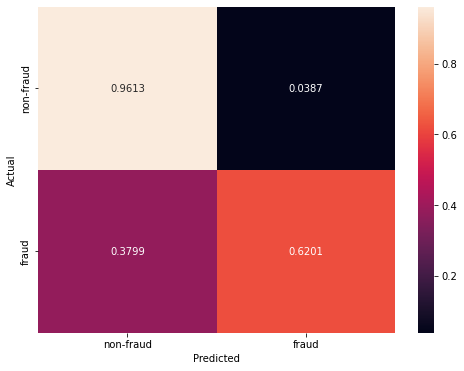

In [60]:
plot_confusion_matrix(y_test, p > 0.5)